## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_paca_pruned.pth
resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
pquant
data
smartpixels


In [3]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

model

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
Begin prunning with MDMM pruning with Unstructured Sparsity metric function

In [4]:
from pquant import get_default_config
from IPython.display import JSON

pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [5]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [6]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [8]:
# from pquant import iterative_train
# """
# Inputs to train_resnet we defined previously are:
#           model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
# """

# trained_model = iterative_train(model = model, 
#                                 config = config, 
#                                 train_func = train_resnet, 
#                                 valid_func = validate_resnet, 
#                                 trainloader = train_loader, 
#                                 testloader = val_loader, 
#                                 device = device, 
#                                 loss_func = loss_function,
#                                 optimizer = optimizer, 
#                                 scheduler = scheduler
#                                 )

In [9]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

/tmp/ipykernel_444236/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


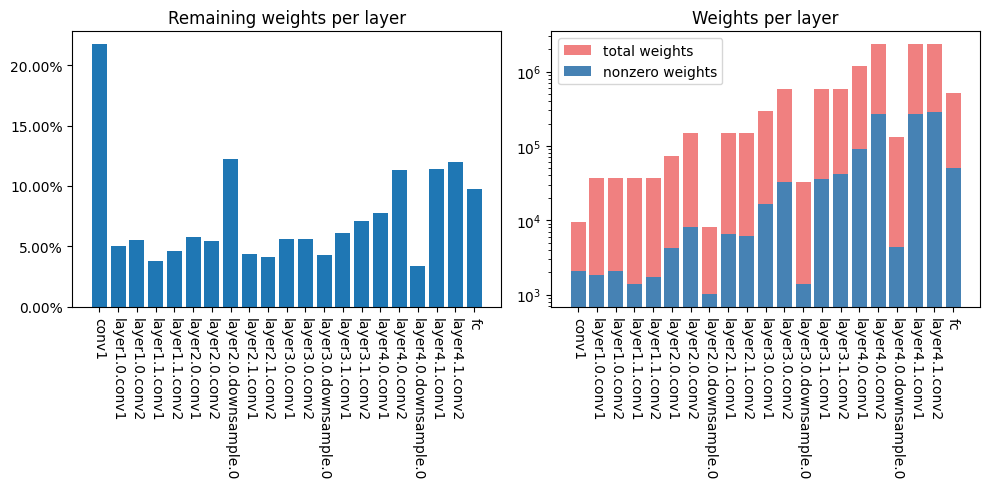

In [10]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [11]:
import math

def visualize_conv_patterns(model, layer_name, max_patterns_to_show=16):
    """
    Visualizes the dominant binary patterns for a specific convolutional layer.
    """
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name and hasattr(module, "pruning_layer"):
            pruning_layer = module.pruning_layer
            if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                target_module = module
                break
    
    if target_module is None:
        print(f"Error: Could not find a PACA-pruned layer named '{layer_name}'.")
        return
        
    metric_fn = target_module.pruning_layer.metric_fn
    # Ensure dominant patterns are selected based on the final weights
    metric_fn._select_dominant_patterns(target_module.weight)
    
    patterns = metric_fn.dominant_patterns
    if patterns is None or patterns.shape[0] == 0:
        print(f"No dominant patterns found for layer '{layer_name}'.")
        return
        
    # Convert to NumPy for plotting
    patterns_np = keras.ops.convert_to_numpy(patterns)
    
    # Get original kernel shape from the weight tensor
    kernel_h, kernel_w = target_module.weight.shape[2], target_module.weight.shape[3]
    
    num_patterns = min(patterns_np.shape[0], max_patterns_to_show)
    
    # Create a subplot grid for the patterns
    cols = math.ceil(math.sqrt(num_patterns))
    rows = math.ceil(num_patterns / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    
    fig.suptitle(f"Dominant Patterns for Layer: {layer_name} (found {patterns_np.shape[0]})", fontsize=16)
    
    for i in range(num_patterns):
        pattern_2d = patterns_np[i].reshape(kernel_h, kernel_w)
        # print(pattern_2d.shape)
        # print(pattern_2d)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1)
        axes[i].set_title(f"Pattern {i+1}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    # Hide any unused subplots
    for j in range(num_patterns, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Add PACA prunning
#### After pruning we will have multiple patterns, so we force all of them to have a lower num,ber of dominant patterns

In [12]:
import yaml 

with open("pquant/configs/config_mdmm_paca.yaml", 'r') as f:
    config = yaml.safe_load(f)
JSON(config)

<IPython.core.display.JSON object>

In [13]:
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model_paca = model.to(device)
model_paca = add_compression_layers(model_paca, config, input_shape)
model_paca

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm_21, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_22, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_23, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_24, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    print()
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖\tEpoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")


def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    num_paca_patterns = 0
    avg_paca_dist = 0.0
    model.eval()
    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖\tEpoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            paca_stats_list = []
            for name, module in model.named_modules():
                if hasattr(module, "pruning_layer"):
                    pruning_layer = module.pruning_layer
                    if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                        metric_fn = pruning_layer.metric_fn
                        num_patterns = 0
                        if metric_fn.dominant_patterns is not None:
                            num_patterns = metric_fn.dominant_patterns.shape[0]

                        total_dist = metric_fn(module.weight).item()
                        avg_dist = total_dist / module.weight.shape[0] if module.weight.shape[0] > 0 else 0
                        
                        stats_str = f"{name} (#Patterns: {num_patterns}, AvgDist: {avg_dist:.4f})"
                        paca_stats_list.append(stats_str)

            paca_summary = " \n| ".join(paca_stats_list) if paca_stats_list else "N/A"

        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, '
              f'Remaining Weights: {ratio * 100:.2f}%, '
              f"PACA Stats: [{paca_summary}]")

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

## Create loss function, scheduler and optimizer

In [33]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [34]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model_paca = iterative_train(model = model_paca, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )

Train ‖	Epoch 0: 100%|██████████| 196/196 [00:04<00:00, 45.62batch/s, loss=0.9378]


Loss=0.9378 | Reg=0.0000


Val   ‖	Epoch 0: 100%|██████████| 196/196 [00:02<00:00, 80.46batch/s]


Accuracy: 71.83%, Remaining Weights: 15.94%, PACA Stats: [conv1 (Patterns: 16, AvgDist: 0.0035) 
| layer1.0.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.0.conv2 (Patterns: 2, AvgDist: 0.0106) 
| layer1.1.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.1.conv2 (Patterns: 1, AvgDist: 0.0156) 
| layer2.0.conv1 (Patterns: 3, AvgDist: 0.0019) 
| layer2.0.conv2 (Patterns: 2, AvgDist: 0.0024) 
| layer2.0.downsample.0 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv1 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv2 (Patterns: 1, AvgDist: 0.0078) 
| layer3.0.conv1 (Patterns: 3, AvgDist: 0.0011) 
| layer3.0.conv2 (Patterns: 3, AvgDist: 0.0011) 
| layer3.0.downsample.0 (Patterns: 1, AvgDist: 0.0039) 
| layer3.1.conv1 (Patterns: 6, AvgDist: 0.0007) 
| layer3.1.conv2 (Patterns: 7, AvgDist: 0.0006) 
| layer4.0.conv1 (Patterns: 5, AvgDist: 0.0002) 
| layer4.0.conv2 (Patterns: 12, AvgDist: 0.0001) 
| layer4.0.downsample.0 (Patterns: 1, AvgDist: 0.0020) 
| layer4.1.conv1 (Patterns: 13, AvgDist: 0.0001)

Train ‖	Epoch 1: 100%|██████████| 196/196 [00:03<00:00, 53.44batch/s, loss=0.9713]


Loss=0.9713 | Reg=0.0000


Val   ‖	Epoch 1: 100%|██████████| 196/196 [00:02<00:00, 80.26batch/s]


Accuracy: 67.67%, Remaining Weights: 15.94%, PACA Stats: [conv1 (Patterns: 16, AvgDist: 0.0034) 
| layer1.0.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.0.conv2 (Patterns: 2, AvgDist: 0.0106) 
| layer1.1.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.1.conv2 (Patterns: 1, AvgDist: 0.0156) 
| layer2.0.conv1 (Patterns: 3, AvgDist: 0.0019) 
| layer2.0.conv2 (Patterns: 2, AvgDist: 0.0024) 
| layer2.0.downsample.0 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv1 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv2 (Patterns: 1, AvgDist: 0.0078) 
| layer3.0.conv1 (Patterns: 3, AvgDist: 0.0011) 
| layer3.0.conv2 (Patterns: 3, AvgDist: 0.0011) 
| layer3.0.downsample.0 (Patterns: 1, AvgDist: 0.0039) 
| layer3.1.conv1 (Patterns: 6, AvgDist: 0.0007) 
| layer3.1.conv2 (Patterns: 7, AvgDist: 0.0006) 
| layer4.0.conv1 (Patterns: 5, AvgDist: 0.0002) 
| layer4.0.conv2 (Patterns: 12, AvgDist: 0.0001) 
| layer4.0.downsample.0 (Patterns: 1, AvgDist: 0.0020) 
| layer4.1.conv1 (Patterns: 13, AvgDist: 0.0001)

Train ‖	Epoch 2: 100%|██████████| 196/196 [00:03<00:00, 53.98batch/s, loss=0.7864]


Loss=0.7864 | Reg=0.0000


Val   ‖	Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 33.37batch/s]


Accuracy: 73.16%, Remaining Weights: 15.94%, PACA Stats: [conv1 (Patterns: 16, AvgDist: 0.0032) 
| layer1.0.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.0.conv2 (Patterns: 2, AvgDist: 0.0106) 
| layer1.1.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.1.conv2 (Patterns: 1, AvgDist: 0.0156) 
| layer2.0.conv1 (Patterns: 3, AvgDist: 0.0018) 
| layer2.0.conv2 (Patterns: 2, AvgDist: 0.0023) 
| layer2.0.downsample.0 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv1 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv2 (Patterns: 1, AvgDist: 0.0078) 
| layer3.0.conv1 (Patterns: 3, AvgDist: 0.0010) 
| layer3.0.conv2 (Patterns: 3, AvgDist: 0.0010) 
| layer3.0.downsample.0 (Patterns: 1, AvgDist: 0.0039) 
| layer3.1.conv1 (Patterns: 6, AvgDist: 0.0007) 
| layer3.1.conv2 (Patterns: 7, AvgDist: 0.0006) 
| layer4.0.conv1 (Patterns: 5, AvgDist: 0.0002) 
| layer4.0.conv2 (Patterns: 12, AvgDist: 0.0001) 
| layer4.0.downsample.0 (Patterns: 1, AvgDist: 0.0020) 
| layer4.1.conv1 (Patterns: 13, AvgDist: 0.0001)

Train ‖	Epoch 3: 100%|██████████| 196/196 [00:06<00:00, 32.25batch/s, loss=1.0095]


Loss=1.0095 | Reg=0.0000


Val   ‖	Epoch 3: 100%|██████████| 196/196 [00:02<00:00, 70.51batch/s]

Accuracy: 68.77%, Remaining Weights: 15.94%, PACA Stats: [conv1 (Patterns: 16, AvgDist: 0.0031) 
| layer1.0.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.0.conv2 (Patterns: 2, AvgDist: 0.0106) 
| layer1.1.conv1 (Patterns: 1, AvgDist: 0.0156) 
| layer1.1.conv2 (Patterns: 1, AvgDist: 0.0156) 
| layer2.0.conv1 (Patterns: 3, AvgDist: 0.0018) 
| layer2.0.conv2 (Patterns: 2, AvgDist: 0.0023) 
| layer2.0.downsample.0 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv1 (Patterns: 1, AvgDist: 0.0078) 
| layer2.1.conv2 (Patterns: 1, AvgDist: 0.0078) 
| layer3.0.conv1 (Patterns: 3, AvgDist: 0.0010) 
| layer3.0.conv2 (Patterns: 3, AvgDist: 0.0010) 
| layer3.0.downsample.0 (Patterns: 1, AvgDist: 0.0039) 
| layer3.1.conv1 (Patterns: 6, AvgDist: 0.0007) 
| layer3.1.conv2 (Patterns: 7, AvgDist: 0.0006) 
| layer4.0.conv1 (Patterns: 5, AvgDist: 0.0002) 
| layer4.0.conv2 (Patterns: 12, AvgDist: 0.0001) 
| layer4.0.downsample.0 (Patterns: 1, AvgDist: 0.0020) 
| layer4.1.conv1 (Patterns: 13, AvgDist: 0.0001)

In [ ]:
from pquant import remove_pruning_from_model

model_paca = remove_pruning_from_model(trained_model_paca, config)
SAVE_PATH = 'resnet_mdmm_unstr_paca_pruned.pth'
torch.save(model_paca.state_dict(), SAVE_PATH)

model_paca = torchvision.models.resnet18()
model_paca.load_state_dict(torch.load(SAVE_PATH))